In [23]:
!pip install pandas scikit-learn matplotlib joblib seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
df = pd.read_csv("spam.csv", encoding="latin-1")
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [26]:
df.isnull().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

In [27]:
df.shape

(5171, 4)

In [28]:
df['label'].value_counts()

label
ham     3672
spam    1499
Name: count, dtype: int64

In [29]:
df['text_len'] = df['text'].apply(len)
df[['label','text_len']].groupby('label').mean()

,text_len
label,
ham,977.008170
spam,1223.256171


In [30]:
df = df.drop(columns=['Unnamed: 0'])
df.head()

,label,text,label_num,text_len
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,327
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,97
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,2524
3,spam,"Subject: photoshop , windows , office . cheap ...",1,414
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,336


In [31]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)        # remove newlines
    text = re.sub(r'[^a-z\s]', '', text)   # keep only letters
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

df['clean_text'] = df['text'].apply(clean_text)
df.head()


,label,text,label_num,text_len,clean_text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,327,subject enron methanol meter this is a follow ...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,97,subject hpl nom for january see attached file ...
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,2524,subject neon retreat ho ho ho we re around to ...
3,spam,"Subject: photoshop , windows , office . cheap ...",1,414,subject photoshop windows office cheap main tr...
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,336,subject re indian springs this deal is to book...


In [32]:
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit on training data only
X_train_vec = vectorizer.fit_transform(X_train)

# Transform test data (without fitting again)
X_test_vec = vectorizer.transform(X_test)

print("X_train_vec shape:", X_train_vec.shape)
print("X_test_vec shape:", X_test_vec.shape)
# Show first 5 rows (dense)


X_train_vec shape: (4136, 5000)
X_test_vec shape: (1035, 5000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [43]:
print(X_train_vec[:5].toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [34]:
vectorizer.get_feature_names_out()[:20]  # first 20 words


array(['aa', 'ab', 'abacustech', 'abdominal', 'abdv', 'abhorred',
       'abiiity', 'ability', 'able', 'absence', 'absolute', 'absolutely',
       'abuse', 'ac', 'accept', 'acceptance', 'accepted', 'access',
       'accessing', 'accessories'], dtype=object)

===== Naive Bayes =====
Accuracy: 0.9487922705314009
Precision: 0.8971061093247589
Recall: 0.93
F1 Score: 0.9132569558101473


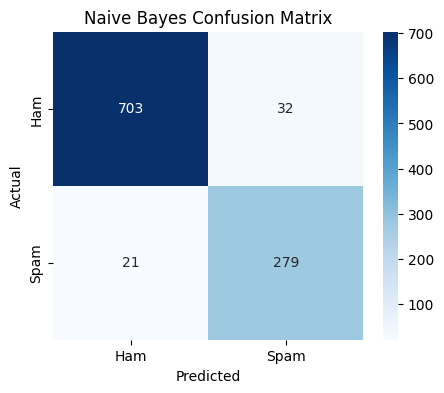

===== Linear SVM =====
Accuracy: 0.9835748792270531
Precision: 0.9764309764309764
Recall: 0.9666666666666667


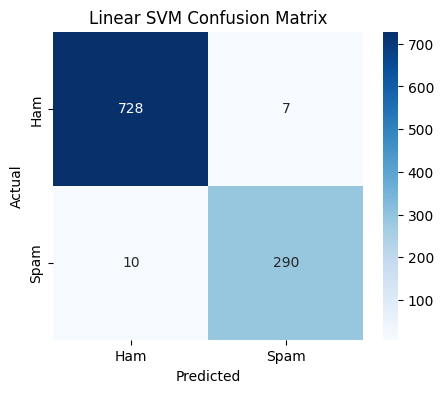

In [38]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize models
models = {
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC(random_state=42)
}

# Train, evaluate and plot confusion matrices
for name, model in models.items():
    # Train
    model.fit(X_train_vec, y_train)
    
    # Predict
    y_pred = model.predict(X_test_vec)
    
    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Print summary metrics
    print(f"===== {name} =====")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    if name == "Naive Bayes":
        print(f"F1 Score: {f1}")
    
    # Confusion Matrix heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} Confusion Matrix")
    plt.show()


In [44]:
from sklearn.metrics import classification_report

# Linear SVM report
y_pred_svm = models["Linear SVM"].predict(X_test_vec)
print("===== Linear SVM - Classification Report =====")
print(classification_report(y_test, y_pred_svm, target_names=['Ham','Spam']))

# Naive Bayes report
y_pred_nb = models["Naive Bayes"].predict(X_test_vec)
print("===== Naive Bayes - Classification Report =====")
print(classification_report(y_test, y_pred_nb, target_names=['Ham','Spam']))


===== Linear SVM - Classification Report =====
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       735
        Spam       0.98      0.97      0.97       300

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035

===== Naive Bayes - Classification Report =====
              precision    recall  f1-score   support

         Ham       0.97      0.96      0.96       735
        Spam       0.90      0.93      0.91       300

    accuracy                           0.95      1035
   macro avg       0.93      0.94      0.94      1035
weighted avg       0.95      0.95      0.95      1035



In [ ]:
import joblib

# Save better model
svm_model = models["Linear SVM"]  # get the trained model from dictionary
joblib.dump(svm_model, "linear_svm_spam_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")  # save TF-IDF vectorizer


['tfidf_vectorizer.pkl']

In [41]:
# Load saved model & vectorizer
loaded_model = joblib.load("linear_svm_spam_model.pkl")
loaded_vectorizer = joblib.load("tfidf_vectorizer.pkl")

# New emails
new_emails = [
    "Congratulations! You won a free iPhone. Click to claim now!",
    "Please review the attached report and send your feedback."
]

# Transform and predict
new_features = loaded_vectorizer.transform(new_emails)
predictions = loaded_model.predict(new_features)

# Print results
for email, pred in zip(new_emails, predictions):
    print(email, "->", "Spam" if pred == 1 else "Ham")


Congratulations! You won a free iPhone. Click to claim now! -> Spam
Please review the attached report and send your feedback. -> Ham
